## Confusion matrix (a.k.a. contingency table).

In [1]:
%matplotlib inline
import re, matplotlib.pyplot as plt, numpy as np
from collections import Counter, defaultdict
from sklearn.naive_bayes import BernoulliNB

In [3]:
from ps1data import absdata
print (sorted(absdata))

['astro-ph.GA', 'cond-mat.mes-hall', 'cs.CV', 'cs.HC', 'cs.LG', 'hep-ph', 'hep-th', 'math.AP', 'physics.app-ph', 'physics.comp-ph', 'q-bio.NC', 'quant-ph']


In [4]:
#def words(txt): return txt.lower().split()
#regular expression works better to tokenize and strip punctuation,
# see https://docs.python.org/3/library/re.html
def words(txt): return re.findall(r"['\w]+", txt.lower())

In [5]:
classnames = ['cs.HC', 'cs.LG', 'cs.CV', 'q-bio.NC'] #just these four as in ps1

In [6]:
vocab = {subj: Counter() for subj in classnames}
for subj in classnames:
  for txt in absdata[subj][:900]:
     for w in set(words(txt)): vocab[subj][w] += 1

In [7]:
#make a combined total_vocab
total_vocab = Counter()
for subj in classnames: total_vocab += vocab[subj]
len(total_vocab)

19253

In [8]:
# take Nf most common terms as features
# see what happens for 1000, probably won't do as well as full vocab
Nf = 1000
Nfvocab, Nfn = zip(*total_vocab.most_common(Nf))
word_index = {w:k for k,w in enumerate(Nfvocab)} #assigns each word an index by rank
set_vocab = set(Nfvocab)

In [9]:
def features(txt):
    f = np.zeros(Nf)
    for w in set(words(txt)) & set_vocab: f[word_index[w]] = 1
    return f  #array of zeros and ones for whether or not feature words occur

In [10]:
X_test = []
X_train = []
for subj in classnames:
    X_train += [features(txt) for txt in absdata[subj][:900]]
    X_test += [features(txt) for txt in absdata[subj][900:]]
    
y_train = np.array([[i]*900 for i in range(4)]).flatten()
y_test = np.array([[i]*100 for i in range(4)]).flatten()

In [11]:
clf = BernoulliNB(alpha=.5)
clf.fit(X_train, y_train) #fit the training data
clf.score(X_test, y_test)

0.85

In [12]:
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold

In [13]:
print (classification_report(y_test, clf.predict(X_test), target_names=classnames))

              precision    recall  f1-score   support

       cs.HC       0.90      0.88      0.89       100
       cs.LG       0.76      0.81      0.78       100
       cs.CV       0.80      0.79      0.79       100
    q-bio.NC       0.96      0.92      0.94       100

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400



[Precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall)


Consider a given digit, say 4, and count the number of times the classifier correctly identifies items actually labelled as 4. This is called the number of "true positives".
The possibilities are:

$tp$ = true positives = labelled as 4, classifier (correctly) gets 4<br>
$fn$ = false negatives = labelled as 4, classifier (incorrectly) get something else<br>
$fp$ = false postives = not labelled as 4, classifier (incorrectly) gets 4<br>
$tn$ = not labelled as 4, classifier (correctly) gets something else

([Type_I_and_type_II_errors](https://en.wikipedia.org/wiki/Type_I_and_type_II_errors):
"In statistical hypothesis testing, a type I error is the rejection of a true null hypothesis (also known as a "false positive" finding or conclusion), while a type II error is the non-rejection of a false null hypothesis (also known as a "false negative" finding or conclusion).")

The *precision* for a class is the ratio of the number of items correctly classified as in that class, divided by the total number of items classified as in that class (i.e., including those incorrectly classified as in that class):

$${\rm Precision} = {tp\over tp+fp}$$

The *recall* for a class is the ratio of the number of items correctly classified as in that class, divided by the total number of items that should have been classified as in the class (i.e., including the ones incorrectly classified as not in that class):

$${\rm Recall} = {tp\over tp+fn}$$

A precision score of 1.0 for a class C means that every item classified as belonging to class C does indeed belong to class C (but says nothing about the number of items from class C that were not classified correctly).<br>
A recall of 1.0 means that every item from class C was classified as belonging to class C (but says nothing about how many items from other classes were incorrectly also classified as belonging to class C).<br>
Frequently, precision and recall have an inverse relationship, where precision for a class can be increased by classifying fewer items as in that class, at the expense of missing items that should have been classified as in the class, lowering recall, and vice versa. 

The precision is also related to what we called the *specificity*, with respect to the medical tests, since it measures the false positive rate; while the recall is related to the *sensitivity*, measuring the false negative rate.

A combined measure of precision and recall is the *f1-score*, defined as their harmonic mean:

$$f1 = 2 {\rm precision\cdot recall \over precision + recall}$$

Its highest value is 1 (perfect precision and recall) and lowest value is 0 (when either of them are zero).

These notions are also encapsulated in the [Confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) (a.k.a. contingency table), implemented in sklearn as [confusion_matrix()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In the tables below, normalizing by the row sums (i.e., dividing each entry of the row by the sum of the row's entries), gives the recalls along the diagonal; and normalizing by the column sums (instead dividing each column by the column sums) gives the precision along the diagonal.

In [14]:
#cmat[i,j] = count of actual class i, predicted class j
cmat = confusion_matrix(y_test, clf.predict(X_test))
cmat

array([[88,  5,  4,  3],
       [ 3, 81, 16,  0],
       [ 4, 16, 79,  1],
       [ 3,  5,  0, 92]])

We can use [ConfusionMatrixDisplay()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) to plot this matrix:

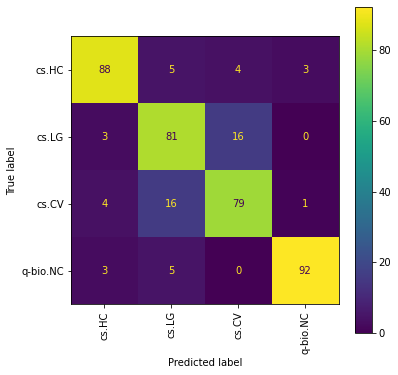

In [24]:
#we can use  ConfusionMatrixDisplay() to plot this matrix
plt.figure(figsize=(6,6))
ConfusionMatrixDisplay(cmat, display_labels=classnames).plot(ax=plt.gca(), xticks_rotation='vertical');

Or even easier, use [plot_confusion_matrix()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html) in a single big step to see in detail which classes were confused:

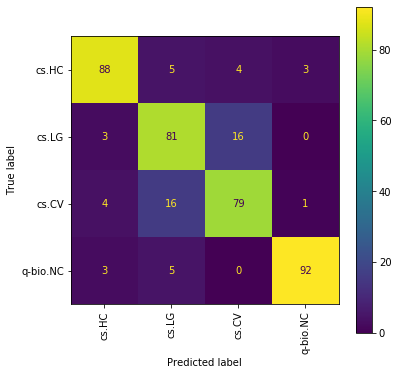

In [15]:
plt.figure(figsize=(6,6))
plot_confusion_matrix(clf, X_test, y_test, ax=plt.gca(), #ax= so that it uses the above figsize
    display_labels=classnames, xticks_rotation='vertical');

But now suppose we want not the confusion matrix for a single train/test split, but instead the average over ten train/test splits. The easiest way I saw was to use [`RepeatedStratifiedKFold()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html) and use `confusion_matrix()` to calculate the successive matrices, then average (but maybe there's an easier way?):

In [25]:
X = np.array([features(txt) for subj in classnames for txt in absdata[subj]]) #all training data
y = np.array([[i]*1000 for i in range(4)]).flatten() #all test data

In [52]:
clf = BernoulliNB(alpha=.5)
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=1) #also ran n_repeats=20 in class
cmat=np.zeros([4,4])

for train_index, test_index in rskf.split(X, y):
#    print("TRAIN:", train_index, "TEST:", test_index) #indices of the split
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train) #note that .fit() always reinitializes starts from scratch
    print(clf.score(X_test, y_test)) #just to see the overall scores
    cmat += confusion_matrix(y_test, clf.predict(X_test))

0.8725
0.8425
0.8425
0.8475
0.8675
0.84
0.87
0.845
0.85
0.8825


In [53]:
cmat /= 10 # to get mean of the ten splits
cmat

array([[89.2,  4.4,  3.5,  2.9],
       [ 5.5, 80.6, 11.3,  2.6],
       [ 4.1, 11.2, 83.9,  0.8],
       [ 7.4,  2.9,  1. , 88.7]])

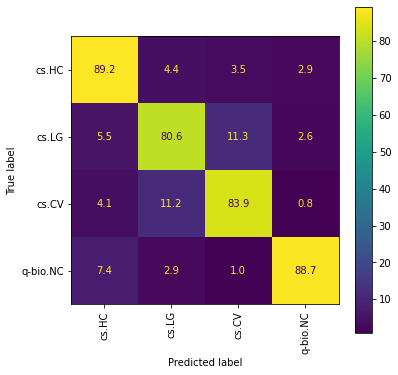

In [54]:
plt.figure(figsize=(6,6))
ConfusionMatrixDisplay(cmat, display_labels=classnames).plot(ax=plt.gca(),# cmap='Reds',
                                xticks_rotation='vertical', values_format='.1f');